# Difference in Differences

### 一、理论介绍 

#### 1.模型形式

#### DID，即双重差分法，在社会科学研究中，是用来估计 干预 和 事件处置效应的一个常用方法。这种‘干预’的特点是，它们并不在同一时间影响所有个体，或者说对个体的影响并不相同。
$$Y_{it}=β_0+β_1*treat_i+β_2*after_t+β_3*treat_i*after_t+α_{it}$$

*若个体i受到政策实施的影响，则个体i属于处理组，对应的$treat_i=1$,反之取值为0

*$after_t$为政策实施的虚拟变量，政策实施之前$after_t$取值为0，政策实施之后$after_t$为1

*$treat_i*after_t$为分组虚拟变量与政策实施虚拟变量之间的交互项，其系数$β_3$反映了政策实施的净效应。

#### 2.平行趋势检验

*平行趋势假设是指：在没有干预发生的情况下，干预组和对照组的y均值差异在不同时间内保持一致。

*判断平行趋势有两种方法：
折线图法：画出事件前每个时期的y值变化，比较干预组与对照组的均值差异是否始终相等。如相等，则说明平行趋势假设通过。
回归法：使用回归方程进行检验，如果在干预开始前的系数是否存在显著不为0。如不存在，则说明平行趋势假设通过 

#### 3.本章研究话题：2015 年 12 月 12 日签署的《巴黎协定》(PA) 对污染企业债券收益率的影响

### 二、导入库

In [14]:
import os
os.chdir(r'C:\01_financial_data\data')
import pandas as pd
import numpy as np
import sqlite3
import linearmodels as lm
import statsmodels.formula.api as smf

from plotnine import *
from scipy.stats import norm
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from regtabletotext import prettify_results

### 三、数据准备

#### 1.导入数据

In [15]:
tidy_finance = sqlite3.connect(
  database="tidy_finance_python.sqlite"
)

fisd = (pd.read_sql_query(
    sql=("SELECT complete_cusip, maturity, offering_amt, " 
         "sic_code FROM fisd"),
    con=tidy_finance,
    parse_dates={"maturity"}
  )
  .dropna()
)

trace_enhanced = (pd.read_sql_query(
    sql=("SELECT cusip_id, trd_exctn_dt, rptd_pr, " 
         "entrd_vol_qt, yld_pt FROM trace_enhanced"),
    con=tidy_finance,
    parse_dates={"trd_exctn_dt"}
  )
  .dropna()
)

In [16]:
fisd 

,complete_cusip,maturity,offering_amt,sic_code
0,000361AA3,2001-11-01,65000.0,3720
1,000361AB1,2003-10-15,50000.0,3720
2,000361AC9,2007-12-15,60000.0,3720
3,000361AQ8,2022-01-15,175000.0,3720
4,00077DAB5,1996-01-12,100000.0,6029
...,...,...,...,...
100605,26054DAA9,2004-12-31,138000.0,2821
100606,262497AC4,2002-11-01,75000.0,2676
100607,263574AB1,2002-09-15,90000.0,5912
100608,266228AP0,2010-03-01,20000.0,4911


In [32]:
trace_enhanced 

,cusip_id,trd_exctn_dt,rptd_pr,entrd_vol_qt,yld_pt,weight,weighted_yield
0,000361AQ8,2014-01-08,105.625,250000.0,6.116614,26406250.0,1.615168e+08
1,000361AQ8,2014-01-09,107.000,1338000.0,5.798856,143166000.0,8.301990e+08
2,000361AQ8,2014-01-14,106.500,250000.0,5.938135,26625000.0,1.581028e+08
3,000361AQ8,2014-01-22,109.200,22000.0,5.020879,2402400.0,1.206216e+07
4,000361AQ8,2014-01-22,107.750,22000.0,5.522170,2370500.0,1.309030e+07
...,...,...,...,...,...,...,...
19046656,00850XAC2,2016-06-09,102.161,2070000.0,2.175917,211473270.0,4.601483e+08
19046657,00850XAC2,2016-06-20,102.526,1000000.0,2.073981,102526000.0,2.126370e+08
19046658,00850XAC2,2016-10-11,101.950,5000000.0,2.183877,509750000.0,1.113231e+09
19046659,00850XAC2,2016-10-19,102.135,250000.0,2.128178,25533750.0,5.434037e+07


#### 2.筛选

*到期时间在协议签订之日起超过一年的债券time_to_maturity>= 1

*识别污染行业--行业代码的前两位数字

In [18]:
treatment_date = pd.to_datetime("2015-12-12")
polluting_industries = [
  49, 13, 45, 29, 28, 33, 40, 20,
  26, 42, 10, 53, 32, 99, 37
]

bonds = (fisd
  .query("offering_amt > 0 & sic_code != 'None'")
  .assign(
    time_to_maturity = lambda x: (
      (x["maturity"]-treatment_date).dt.days / 365
    ),
    sic_code = lambda x: (
      x["sic_code"].astype(str).str[:2].astype(int)
    ),
    log_offering_amt = lambda x: (
      np.log(x["offering_amt"])
    )
  )
  .query("time_to_maturity >= 1")
  .rename(columns={"complete_cusip": "cusip_id"})
  .get(["cusip_id", "time_to_maturity", 
        "log_offering_amt", "sic_code"])
  .assign(
    polluter = lambda x: (
      x["sic_code"].isin(polluting_industries)
    )
  )
  .reset_index(drop=True)
)

In [19]:
bonds 

,cusip_id,time_to_maturity,log_offering_amt,sic_code,polluter
0,000361AQ8,6.098630,12.072541,37,True
1,001546AL4,4.427397,12.899220,33,True
2,001546AM2,6.306849,12.611538,33,True
3,001546AS9,5.808219,12.971540,33,True
4,001546AU4,11.263014,12.899220,33,True
...,...,...,...,...,...
63982,21871XAD1,11.320548,14.030807,63,False
63983,21871XAF6,13.323288,13.815511,63,False
63984,21871XAH2,16.326027,14.220920,63,False
63985,21871XAK5,26.331507,13.109785,63,False


#### 3.债券数据汇总

*只考虑报告价格rptd_pr大于 25 的交易

*交易次数超过 5 次的债券

*汇总债券特定信息与 TRACE 数据

In [33]:
trace_enhanced = (trace_enhanced
  .query("rptd_pr > 25")
  .assign(
    weight = lambda x: x["entrd_vol_qt"] * x["rptd_pr"],
  )
  .assign(
     weighted_yield = lambda x: x["weight"] * x["yld_pt"]
  )
)


In [34]:
trace_enhanced

,cusip_id,trd_exctn_dt,rptd_pr,entrd_vol_qt,yld_pt,weight,weighted_yield
0,000361AQ8,2014-01-08,105.625,250000.0,6.116614,26406250.0,1.615168e+08
1,000361AQ8,2014-01-09,107.000,1338000.0,5.798856,143166000.0,8.301990e+08
2,000361AQ8,2014-01-14,106.500,250000.0,5.938135,26625000.0,1.581028e+08
3,000361AQ8,2014-01-22,109.200,22000.0,5.020879,2402400.0,1.206216e+07
4,000361AQ8,2014-01-22,107.750,22000.0,5.522170,2370500.0,1.309030e+07
...,...,...,...,...,...,...,...
19046656,00850XAC2,2016-06-09,102.161,2070000.0,2.175917,211473270.0,4.601483e+08
19046657,00850XAC2,2016-06-20,102.526,1000000.0,2.073981,102526000.0,2.126370e+08
19046658,00850XAC2,2016-10-11,101.950,5000000.0,2.183877,509750000.0,1.113231e+09
19046659,00850XAC2,2016-10-19,102.135,250000.0,2.128178,25533750.0,5.434037e+07


In [35]:
trace_aggregated = (trace_enhanced
  .groupby(["cusip_id", "trd_exctn_dt"])
  .aggregate(
    weighted_yield_sum = ("weighted_yield", "sum"),
    weight_sum = ("weight", "sum"),
    trades = ("rptd_pr", "count")
  )
  .reset_index()
  .assign(
    avg_yield = lambda x: (
      x["weighted_yield_sum"] / x["weight_sum"]
    )
  )
  .dropna(subset=["avg_yield"])
  .query("trades >= 5")
  .assign(
    trd_exctn_dt = lambda x: (
      pd.to_datetime(x["trd_exctn_dt"])
    )
  )
  .assign(
    month = lambda x: (
      x["trd_exctn_dt"] - pd.tseries.offsets.MonthBegin()
    )
  )
)

date_index = (trace_aggregated
  .groupby(["cusip_id", "month"])["trd_exctn_dt"]
  .idxmax()
)

trace_aggregated = (trace_aggregated
  .loc[date_index]
  .get(["cusip_id", "month", "avg_yield"])
)

In [36]:
trace_aggregated

,cusip_id,month,avg_yield
6,000361AQ8,2014-01-01,5.679322
8,000361AQ8,2014-02-01,5.504475
12,000361AQ8,2014-03-01,5.099354
31,000361AQ8,2014-05-01,4.925882
55,000361AQ8,2014-08-01,4.253037
...,...,...,...
2592604,989822AA9,2016-07-01,3.969429
2592624,989822AA9,2016-08-01,3.979167
2592639,989822AA9,2016-09-01,3.812805
2592658,989822AA9,2016-10-01,4.077419


In [23]:
bonds_panel = (bonds
  .merge(trace_aggregated, how="inner", on="cusip_id")
  .dropna()
)

In [24]:
bonds_panel 

,cusip_id,time_to_maturity,log_offering_amt,sic_code,polluter,month,avg_yield
0,000361AQ8,6.098630,12.072541,37,True,2014-01-01,5.679322
1,000361AQ8,6.098630,12.072541,37,True,2014-02-01,5.504475
2,000361AQ8,6.098630,12.072541,37,True,2014-03-01,5.099354
3,000361AQ8,6.098630,12.072541,37,True,2014-05-01,4.925882
4,000361AQ8,6.098630,12.072541,37,True,2014-08-01,4.253037
...,...,...,...,...,...,...,...
127541,07330NAK1,1.808219,13.527828,60,False,2016-05-01,1.169543
127542,07330NAK1,1.808219,13.527828,60,False,2016-08-01,1.000203
127543,07330NAK1,1.808219,13.527828,60,False,2016-09-01,1.292501
127544,07330NAK1,1.808219,13.527828,60,False,2016-10-01,1.135503


#### 4.建立treated指标 

*post_period与polluter指标的乘积

In [25]:
bonds_panel = (bonds_panel
  .assign(
    post_period = lambda x: (
      x["month"] >= (treatment_date - 
                      pd.tseries.offsets.MonthBegin())
    )
  )
  .assign(
    treated = lambda x: x["polluter"] & x["post_period"]
  )
  .assign(
    month_cat = lambda x: pd.Categorical(x["month"], 
                                         ordered=True)
  )
)

In [27]:
bonds_panel 

,cusip_id,time_to_maturity,log_offering_amt,sic_code,polluter,month,avg_yield,post_period,treated,month_cat
0,000361AQ8,6.098630,12.072541,37,True,2014-01-01,5.679322,False,False,2014-01-01
1,000361AQ8,6.098630,12.072541,37,True,2014-02-01,5.504475,False,False,2014-02-01
2,000361AQ8,6.098630,12.072541,37,True,2014-03-01,5.099354,False,False,2014-03-01
3,000361AQ8,6.098630,12.072541,37,True,2014-05-01,4.925882,False,False,2014-05-01
4,000361AQ8,6.098630,12.072541,37,True,2014-08-01,4.253037,False,False,2014-08-01
...,...,...,...,...,...,...,...,...,...,...
127541,07330NAK1,1.808219,13.527828,60,False,2016-05-01,1.169543,True,False,2016-05-01
127542,07330NAK1,1.808219,13.527828,60,False,2016-08-01,1.000203,True,False,2016-08-01
127543,07330NAK1,1.808219,13.527828,60,False,2016-09-01,1.292501,True,False,2016-09-01
127544,07330NAK1,1.808219,13.527828,60,False,2016-10-01,1.135503,True,False,2016-10-01


#### 5.描述性统计

In [28]:
bonds_panel_summary = (bonds_panel
  .melt(
    var_name="measure",
    value_vars=["avg_yield", "time_to_maturity", 
                "log_offering_amt"]
  )
  .groupby("measure")
  .describe(percentiles=[0.05, 0.5, 0.95])
)

np.round(bonds_panel_summary, 2)

value                                                
                     count   mean   std   min     5%    50%    95%     max
measure                                                                   
avg_yield         127546.0   4.08  4.21  0.06   1.27   3.38   8.11  127.97
log_offering_amt  127546.0  13.27  0.82  4.64  12.21  13.22  14.51   16.52
time_to_maturity  127546.0   8.55  8.41  1.01   1.50   5.81  27.41  100.70

### 四、回归

*没有固定效应的 OLS 回归

*个体 ( cusip_id) 和时间 ( month) 固定效应

In [29]:
model_without_fe = lm.PanelOLS.from_formula(
  formula=("avg_yield ~ treated + post_period + polluter "
           "+ log_offering_amt + time_to_maturity + 1"),
  data=bonds_panel.set_index(["cusip_id", "month"]),
).fit()

model_with_fe = lm.PanelOLS.from_formula(
  formula=("avg_yield ~ treated + "
           "EntityEffects + TimeEffects"),
  data=bonds_panel.set_index(["cusip_id", "month"]),
).fit()

prettify_results([
  model_without_fe, model_with_fe
])

Dependent var.      avg_yield      avg_yield

Intercept         10.733 (57.06)
treated            0.453 (9.14)   0.974 (29.3)
post_period       -0.178 (-6.04)
polluter          0.486 (15.43)
log_offering_amt  -0.55 (-38.99)
time_to_maturity  0.058 (41.53)

Fixed effects                     Entity, Time
VCOV type           Unadjusted     Unadjusted
Observations         127,546        127,546
R2 (incl. FE)         0.032          0.648
Within R2             0.004          0.012

Note: t-statistics in parentheses


### 五、平行趋势检验 

1.检验一：OLS回归

*将每组的treated和post_period指标替换为月份虚拟值

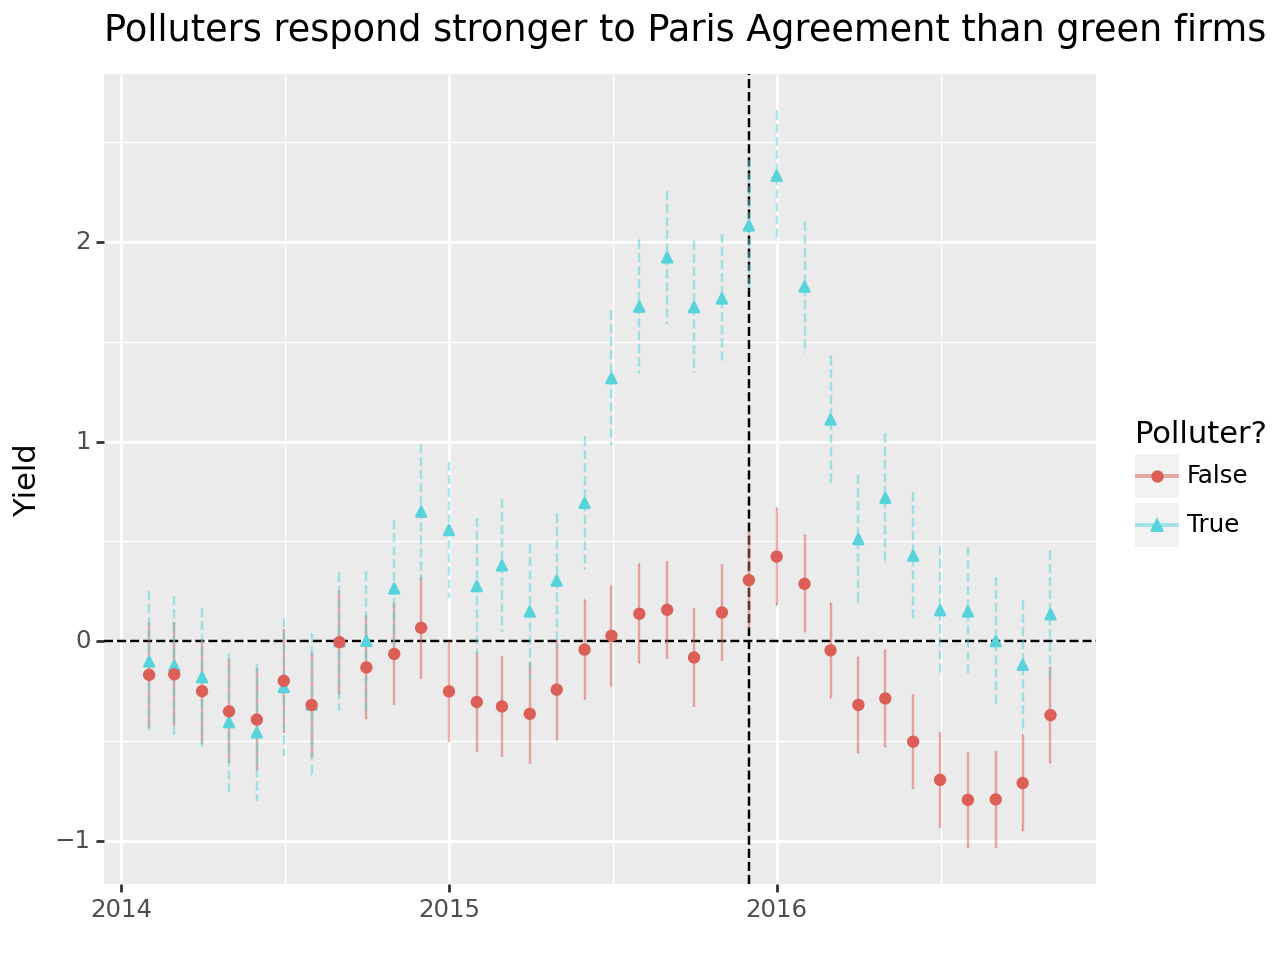

In [30]:
model_without_fe_time = (smf.ols(
    formula=("avg_yield ~ polluter + month_cat:polluter "
             "+ time_to_maturity + log_offering_amt"),
    data=bonds_panel)
  .fit()
  .summary()
)

model_without_fe_coefs = (
  pd.DataFrame(model_without_fe_time.tables[1].data[1:],
               columns=["term", "estimate", "std_error",
                          "t_stat", "p_value", "ci_1", "ci_2"])
  .query("term.str.contains('month_cat')")
  .assign(month = lambda x: x["term"].str.extract(r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})"))
  .assign(month=lambda x: pd.to_datetime(x["month"]))
  .assign(treatment = lambda x: x["term"].str.contains("True"))
  .assign(estimate = lambda x: x["estimate"].astype(float),
          std_error = lambda x: x["std_error"].astype(float))
  .assign(ci_up = lambda x: x["estimate"] + norm.ppf(0.975) * x["std_error"],
          ci_low = lambda x: x["estimate"] + norm.ppf(0.025) * x["std_error"])
)

polluters_plot = (
  ggplot(model_without_fe_coefs, aes(x="month", y="estimate",
         color="treatment", linetype="treatment", shape="treatment")) +
  geom_vline(xintercept=pd.to_datetime(treatment_date) -
             pd.tseries.offsets.MonthBegin(), linetype="dashed") +
  geom_hline(yintercept=0, linetype="dashed") +
  geom_errorbar(aes(ymin="ci_low", ymax="ci_up"), alpha=0.5) +
  geom_point() +
  guides(linetype=None) + 
  labs(
      x="", y="Yield", shape="Polluter?", color="Polluter?",
      title="Polluters respond stronger to Paris Agreement than green firms"
    ) +
  scale_linetype_manual(values=["solid", "dashed"]) +
  scale_x_datetime(breaks=date_breaks("1 year"), 
                   labels=date_format("%Y")) 
)
polluters_plot.draw()

结论：在 2014 年的大部分时间里，两组的收益率变化一致。然而，从2014年底开始，收益率开始出现分化，在协议签署前后达到最高差异。此后，双方的收益率再次下降，污染企业的收益率与2014年初持平。而非污染企业的收益率在协议签署后甚至明显低于污染企业。

2.检验二：固定效应模型

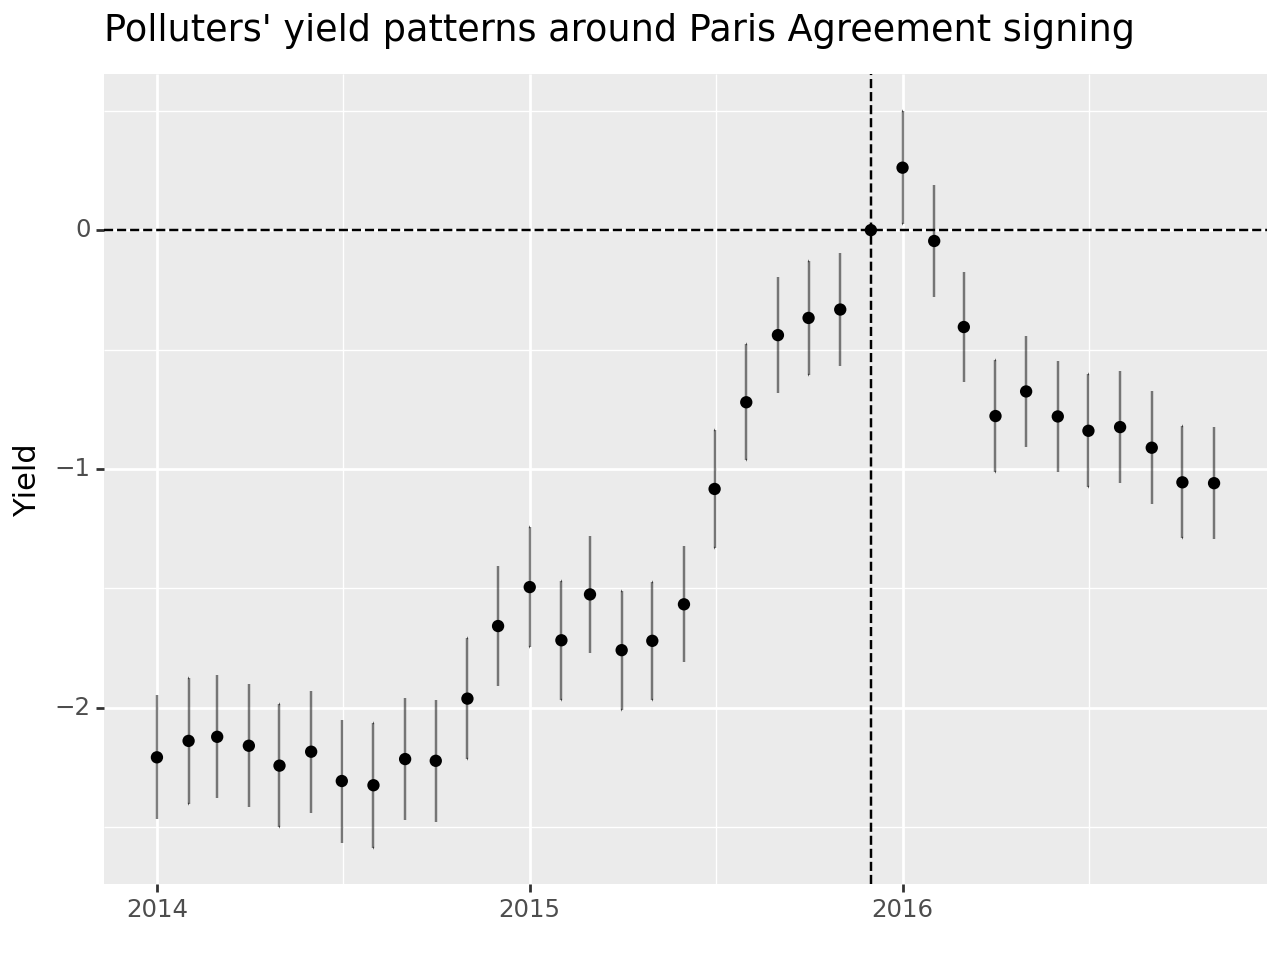

In [31]:
bonds_panel_alt = (bonds_panel
  .assign(
    diff_to_treatment = lambda x:
          np.round(((x["month"] - (treatment_date - pd.tseries.offsets.MonthBegin())).dt.days / 365) * 12, 0).astype(int)
  )
)

variables = (bonds_panel_alt[["diff_to_treatment", "month"]]
  .drop_duplicates()
  .sort_values("month")
  .copy()
  .assign(variable_name=np.nan)
  .reset_index(drop=True)
)

formula = "avg_yield ~ 1 + "

for j in range(variables.shape[0]):
    if variables["diff_to_treatment"].iloc[j] != 0:
        old_names = list(bonds_panel_alt.columns)
        bonds_panel_alt["new_var"] = (bonds_panel_alt["diff_to_treatment"] ==
                                      variables["diff_to_treatment"]
                                      .iloc[j]) & bonds_panel_alt["polluter"]
        diff_to_treatment_value = variables["diff_to_treatment"].iloc[j]
        direction = "lag" if diff_to_treatment_value < 0 else "lead"
        abs_diff_to_treatment = int(abs(diff_to_treatment_value))
        new_var_name = f"{direction}{abs_diff_to_treatment}"
        variables.at[j, "variable_name"] = new_var_name
        bonds_panel_alt[new_var_name] = bonds_panel_alt["new_var"]
        formula += (f" + {new_var_name}" if j > 0 else new_var_name)

formula = formula + " + EntityEffects + TimeEffects"

model_with_fe_time = (lm.PanelOLS.from_formula(
    formula=formula,
    data=bonds_panel_alt.set_index(["cusip_id", "month"]))
  .fit()
  .summary
)

lag0_row = pd.DataFrame({
  "term": ["lag0"],
  "estimate": [0],
  "ci_1": [0],
  "ci_2": [0],
  "ci_up": [0],
  "ci_low": [0],
  "month": [treatment_date - pd.tseries.offsets.MonthBegin()]
})

model_with_fe_time_coefs = (
  pd.DataFrame(model_with_fe_time.tables[1].data[1:],
               columns=["term", "estimate", "std_error",
                        "t_stat", "p_value", "ci_1", "ci_2"])
  .assign(term=lambda x: x["term"].str.replace("[T.True]", ""))
  .assign(estimate=lambda x: x["estimate"].astype(float),
          std_error=lambda x: x["std_error"].astype(float))
  .assign(ci_up=lambda x: x["estimate"] + norm.ppf(0.975) * x["std_error"],
          ci_low=lambda x: x["estimate"] + norm.ppf(0.025) * x["std_error"])
  .merge(variables, how="left", left_on="term", right_on="variable_name")
  .drop(columns="variable_name")
  .query("term != 'Intercept'")
)

model_with_fe_time_coefs = pd.concat(
    [model_with_fe_time_coefs, lag0_row], ignore_index=True)

polluter_plot = (
  ggplot(model_with_fe_time_coefs, aes(x="month", y="estimate")) +
  geom_vline(aes(xintercept=treatment_date - pd.tseries.offsets.MonthBegin()), 
                 linetype="dashed") +
  geom_hline(aes(yintercept=0), linetype="dashed") +
  geom_errorbar(aes(ymin="ci_low", ymax="ci_up"), alpha=0.5) +
  geom_point(aes(y="estimate")) +
  labs(x="", y="Yield",
       title="Polluters' yield patterns around Paris Agreement signing") +
  scale_x_datetime(breaks=date_breaks("1 year"), 
                   labels=date_format("%Y")) 
)
polluter_plot.draw()

结论：从 2014 年底开始，污染者的产量模式显示出相当大的预期效应。协议签署后，产量仅略有增加。然而，与简单模型相反，我们并没有看到完全逆转回协议前水平。即使在签署一年后，污染企业的产量仍保持在明显较高的水平。

### 六、练习题 

1.The 46th President of the US rejoined the Paris Agreement in February 2021. Repeat the difference in differences analysis for the day of his election victory. Note that you will also have to download new TRACE data. How did polluters’ yields react to this action?

*未下载数据，仅作步骤。将分析的时间点更新为新的关键时间点，即美国总统选举胜利的日期。

In [ ]:
# 更新新的处理效应时间点
new_treatment_date = pd.to_datetime("2021-02-01")

# 更新处理效应指示变量
bonds_panel_alt = bonds_panel_alt.assign(
    new_post_period=lambda x: x["month"] >= (new_treatment_date - pd.tseries.offsets.MonthBegin()),
    new_treated=lambda x: x["polluter"] & x["new_post_period"]
)

# 重新运行 PanelOLS 模型
new_model_with_fe_time = lm.PanelOLS.from_formula(
    formula=("avg_yield ~ new_treated + "
             "EntityEffects + TimeEffects"),
    data=bonds_panel_alt.set_index(["cusip_id", "month"]),
).fit()

# 输出新模型结果
print(new_model_with_fe_time)

2.Based on the exercise on ratings in TRACE and FISD, include ratings as a control variable in the analysis above. Do the results change?

*没有评级数据，仅作代码展示。在模型中添加评级变量作为控制变量，并重新运行分析。

In [ ]:
# 合并评级数据
ratings_data = pd.read_csv("path/to/ratings_data.csv")  # 替换为实际的评级数据路径
merged_data = pd.merge(bonds_panel, ratings_data, on="cusip_id", how="left")

# 更新 Panel 数据集
bonds_panel_updated = merged_data.assign(
    rating_variable=lambda x: x["rating_variable"],  # 替换为实际的评级变量名称
)

# 重新运行 PanelOLS 模型
model_with_ratings = lm.PanelOLS.from_formula(
    formula=("avg_yield ~ treated + post_period + polluter + "
             "log_offering_amt + time_to_maturity + rating_variable + "
             "EntityEffects + TimeEffects"),
    data=bonds_panel_updated.set_index(["cusip_id", "month"]),
).fit()

# 输出新模型结果
print(model_with_ratings)